In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/data.csv")

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


In [ ]:
print("Shape of dataset:", df.shape)
print("First 20 rows:")
display(df.head(20))

Shape of dataset: (294, 14)
First 20 rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,?,?,?,0
1,29,1,2,120,243,0,0,160,0,0.0,?,?,?,0
2,29,1,2,140,?,0,0,170,0,0.0,?,?,?,0
3,30,0,1,170,237,0,1,170,0,0.0,?,?,6,0
4,31,0,2,100,219,0,1,150,0,0.0,?,?,?,0
5,32,0,2,105,198,0,0,165,0,0.0,?,?,?,0
6,32,1,2,110,225,0,0,184,0,0.0,?,?,?,0
7,32,1,2,125,254,0,0,155,0,0.0,?,?,?,0
8,33,1,3,120,298,0,0,185,0,0.0,?,?,?,0
9,34,0,2,130,161,0,0,190,0,0.0,?,?,?,0


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         294 non-null    int64  
 1   sex         294 non-null    int64  
 2   cp          294 non-null    int64  
 3   trestbps    294 non-null    object 
 4   chol        294 non-null    object 
 5   fbs         294 non-null    object 
 6   restecg     294 non-null    object 
 7   thalach     294 non-null    object 
 8   exang       294 non-null    object 
 9   oldpeak     294 non-null    float64
 10  slope       294 non-null    object 
 11  ca          294 non-null    object 
 12  thal        294 non-null    object 
 13  num         294 non-null    int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 32.3+ KB
None


In [ ]:
print(df.isnull().sum())

age           0
sex           0
cp            0
trestbps      0
chol          0
fbs           0
restecg       0
thalach       0
exang         0
oldpeak       0
slope         0
ca            0
thal          0
num           0
dtype: int64


In [ ]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,?,?,?,0
1,29,1,2,120,243,0,0,160,0,0.0,?,?,?,0
2,29,1,2,140,?,0,0,170,0,0.0,?,?,?,0
3,30,0,1,170,237,0,1,170,0,0.0,?,?,6,0
4,31,0,2,100,219,0,1,150,0,0.0,?,?,?,0


In [ ]:
# Count missing values in the problematic features
missing_analysis = pd.DataFrame({
    'feature': ['slope', 'thal', 'ca'],
    'total_missing': [
        (df['slope'] == '?').sum(),
        (df['thal'] == '?').sum(),
        (df['ca'] == '?').sum()
    ],
    'missing_percentage': [
        ((df['slope'] == '?').sum() / len(df)) * 100,
        ((df['thal'] == '?').sum() / len(df)) * 100,
        ((df['ca'] == '?').sum() / len(df)) * 100
    ]
})

print("Missing Value Analysis:")
print(missing_analysis)

Missing Value Analysis:
  feature  total_missing  missing_percentage
0   slope            190           64.625850
1    thal            266           90.476190
2      ca            291           98.979592


In [ ]:
def clean_heart_disease_data(df):
    df_clean = df.copy()
    drop_cols = ['slope', 'thal', 'ca']
    df_clean.drop(columns=[c for c in drop_cols if c in df_clean.columns], inplace=True)
    df_clean.columns = df_clean.columns.str.strip().str.lower()
    df_clean.replace('?', np.nan, inplace=True)

    num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang']

    for col in num_cols + cat_cols:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    df_clean.dropna(inplace=True)
    df_clean['heart_disease'] = (df_clean['num'] > 0).astype(int)
    return df_clean

df_clean = clean_heart_disease_data(df)

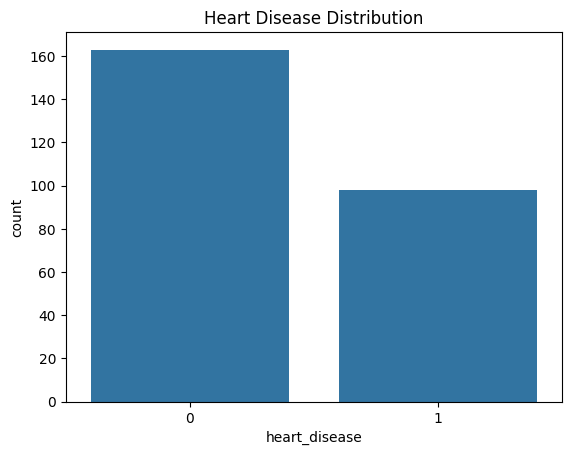

In [ ]:
# Target distribution
sns.countplot(x='heart_disease', data=df_clean)
plt.title('Heart Disease Distribution')
plt.show()

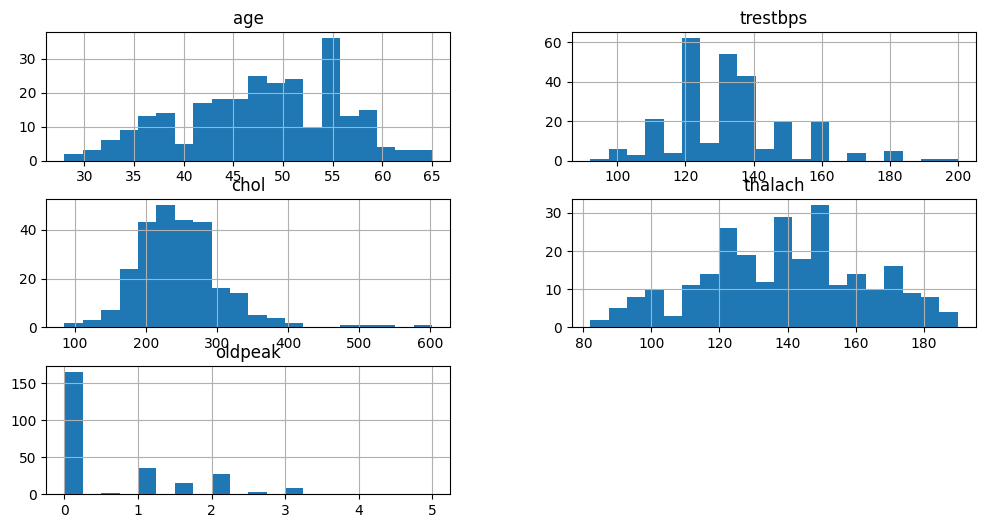

In [ ]:
# Numerical feature distributions
num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df_clean[num_cols].hist(bins=20, figsize=(12,6))
plt.show()

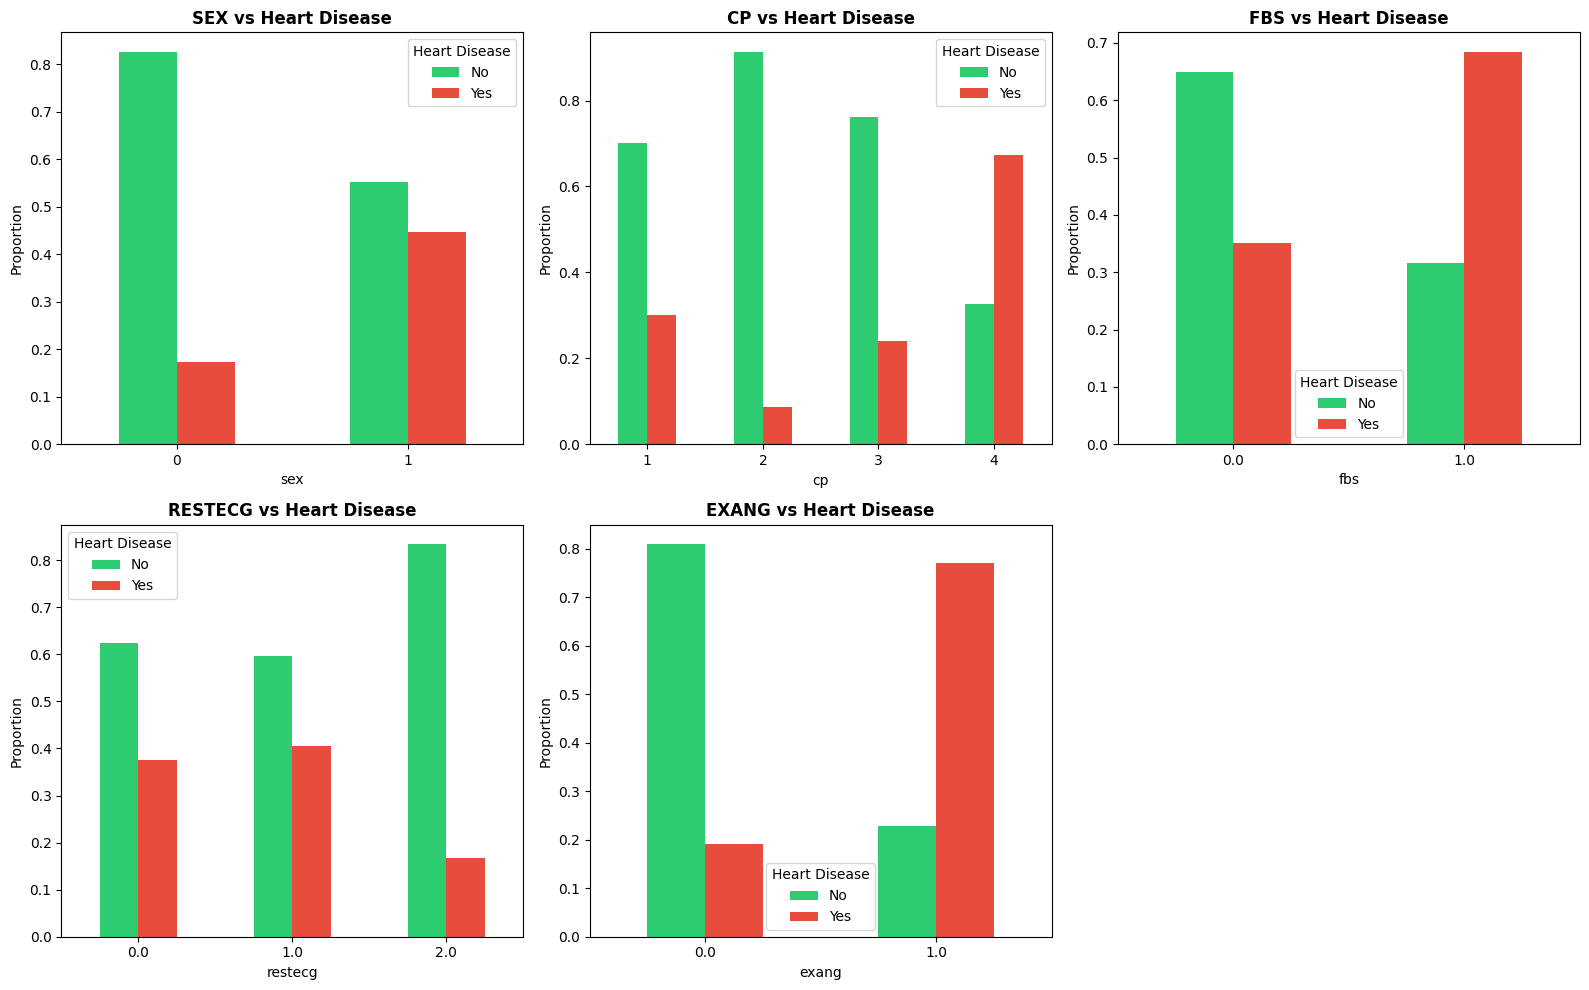

In [ ]:
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang']
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_features):
    pd.crosstab(df_clean[col], df_clean['heart_disease'], normalize='index').plot(
        kind='bar', ax=axes[idx], stacked=False, color=['#2ecc71', '#e74c3c']
    )
    axes[idx].set_title(f'{col.upper()} vs Heart Disease', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Proportion')
    axes[idx].legend(title='Heart Disease', labels=['No', 'Yes'])
    axes[idx].tick_params(axis='x', rotation=0)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

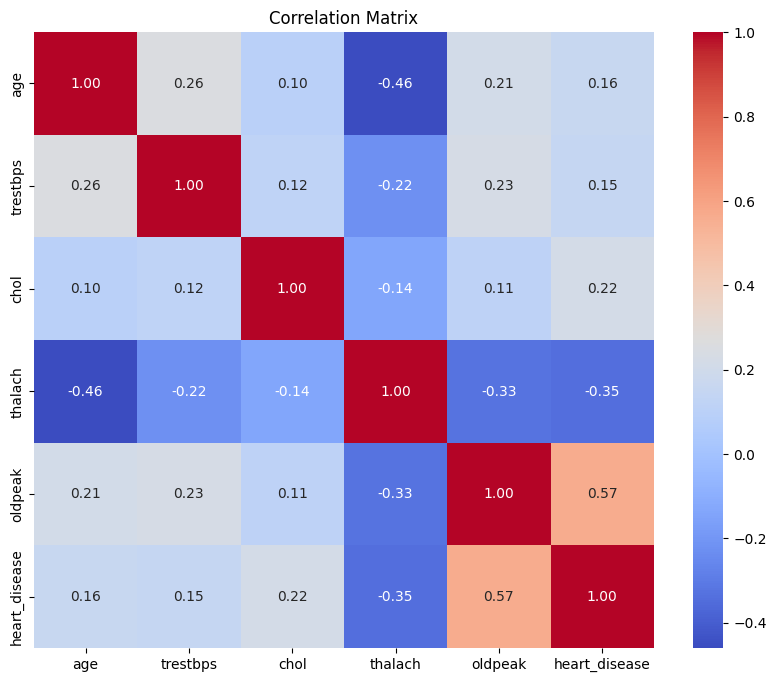

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_clean[num_cols + ['heart_disease']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

#Modeling


In [ ]:
X = df_clean.drop(['heart_disease','num'], axis=1)
y = df_clean['heart_disease']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_pred_proba_lr)

print(f"Accuracy: {lr_accuracy:.4f}")
print(f"ROC AUC: {lr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['No Disease', 'Disease']))

Accuracy: 0.8491
ROC AUC: 0.9227

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.88      0.88      0.88        33
     Disease       0.80      0.80      0.80        20

    accuracy                           0.85        53
   macro avg       0.84      0.84      0.84        53
weighted avg       0.85      0.85      0.85        53



In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_pred_proba_rf)

print(f"Accuracy: {rf_accuracy:.4f}")
print(f"ROC AUC: {rf_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['No Disease', 'Disease']))


Accuracy: 0.8679
ROC AUC: 0.9167

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.88      0.91      0.90        33
     Disease       0.84      0.80      0.82        20

    accuracy                           0.87        53
   macro avg       0.86      0.85      0.86        53
weighted avg       0.87      0.87      0.87        53



In [ ]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]

gb_accuracy = accuracy_score(y_test, y_pred_gb)
gb_auc = roc_auc_score(y_test, y_pred_proba_gb)

print(f"Accuracy: {gb_accuracy:.4f}")
print(f"ROC AUC: {gb_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=['No Disease', 'Disease']))

Accuracy: 0.8302
ROC AUC: 0.9030

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.85      0.88      0.87        33
     Disease       0.79      0.75      0.77        20

    accuracy                           0.83        53
   macro avg       0.82      0.81      0.82        53
weighted avg       0.83      0.83      0.83        53



In [ ]:
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"ROC AUC: {xgb_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['No Disease', 'Disease']))


Accuracy: 0.8302
ROC AUC: 0.8879

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.85      0.88      0.87        33
     Disease       0.79      0.75      0.77        20

    accuracy                           0.83        53
   macro avg       0.82      0.81      0.82        53
weighted avg       0.83      0.83      0.83        53



In [ ]:
svm_model = SVC(kernel='linear', random_state=42, class_weight='balanced', probability=True)
svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_auc = roc_auc_score(y_test, y_pred_proba_svm)

print(f"Accuracy: {svm_accuracy:.4f}")
print(f"ROC AUC: {svm_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=['No Disease', 'Disease']))

Accuracy: 0.9057
ROC AUC: 0.9227

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.94      0.91      0.92        33
     Disease       0.86      0.90      0.88        20

    accuracy                           0.91        53
   macro avg       0.90      0.90      0.90        53
weighted avg       0.91      0.91      0.91        53



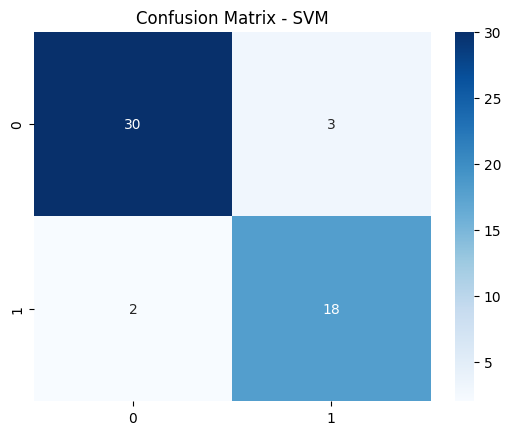

In [ ]:
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SVM')
plt.show()

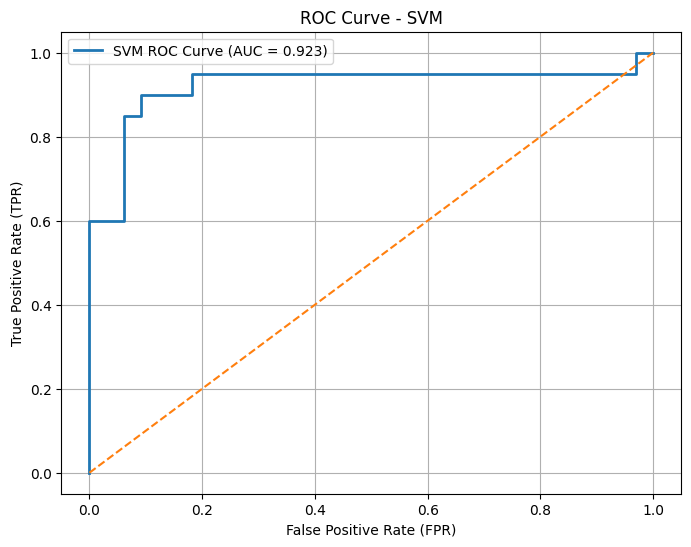

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_svm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"SVM ROC Curve (AUC = {roc_auc:.3f})", linewidth=2)

plt.plot([0,1], [0,1], linestyle='--')

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve - SVM")
plt.legend()
plt.grid(True)
plt.show()